## TODO:
- Implement "harvest rain"
- Check with TL harvest dates
- Implement floraison period


,debourrement,floraison,veraison,vendanges,Debourrement-floraison interval,Floraison-veraison interval,Veraison-Harvest interval,Growing season duration
vintage,,,,,,,,
1961,1961-03-10,1961-05-29,1961-08-08,1961-09-23,80,71,46,197
1962,1962-04-18,1962-06-15,1962-08-18,1962-10-10,58,64,53,175
1963,1963-04-10,1963-06-18,1963-08-15,1963-10-16,69,58,62,189
1964,1964-04-05,1964-06-14,1964-08-13,1964-10-01,70,60,49,179
1965,1965-03-31,1965-06-28,1965-08-15,1965-10-10,89,48,56,193


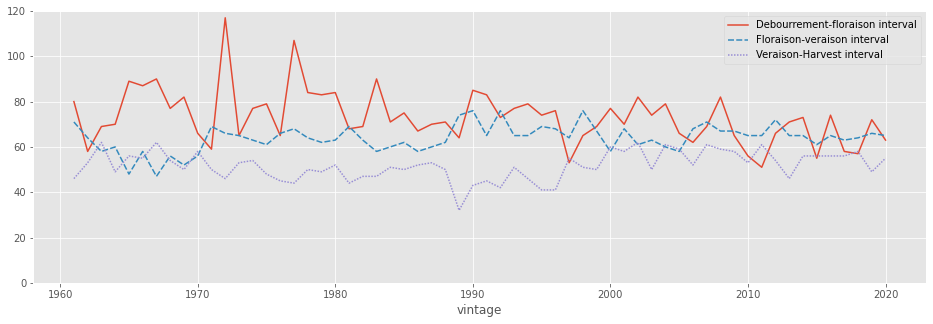

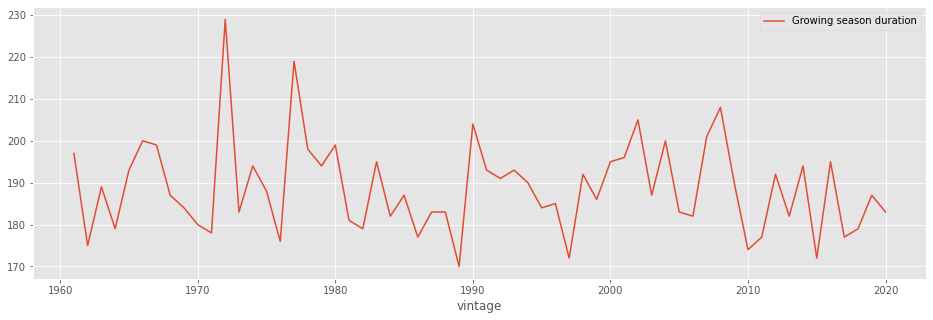

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

plt.rcParams["figure.figsize"] = (16, 5)

pheno = pd.read_excel('data/pheno_latour.xlsx', index_col=0)
pheno['vendanges'] = pd.to_datetime(pheno['vendanges'].dt.date)
pheno['veraison'] = pd.to_datetime(pheno['veraison'].dt.date)

pheno['Debourrement-floraison interval'] = (pheno['floraison'] - pheno['debourrement']).dt.days
pheno['Floraison-veraison interval'] = (pheno['veraison'] - pheno['floraison']).dt.days
pheno['Veraison-Harvest interval'] = (pheno['vendanges'] - pheno['veraison']).dt.days
pheno['Growing season duration'] = (pheno['vendanges'] - pheno['debourrement']).dt.days

display(pheno.head())

intervalles = pheno[['Debourrement-floraison interval', 'Floraison-veraison interval', 'Veraison-Harvest interval']]
plt.figure(figsize=(16,5))
plt.ylim((0,120))
sns.lineplot(data=intervalles)
plt.show()

plt.figure(figsize=(16,5))
sns.lineplot(data=pheno[['Growing season duration']])
plt.show()

In [173]:
weather = pd.read_csv('data/weather_merignac_daily.csv', parse_dates=['Date']).set_index('Date')
weather['Frost'] = (weather['Tn'] < 0).astype(int)
weather['GDD10'] = (weather['Tm'] < 10).astype(int)* (weather['Tm'] - 10)
weather['DTR'] = weather['Tx'] - weather['Tn']
weather['CI'] = (weather['Tn'] < 15).astype(int)
weather['Huglin'] = ((weather['Tx']-10) + (weather['Tm']-10))/2
ORIG_WEATHER_FEATURES = list(weather.columns)


In [174]:
features = list(weather.columns)
vintages = list(pheno.index)

df = pd.DataFrame(index = vintages)
events = ['debourrement', 'floraison', 'veraison', 'vendanges']


for feature in features:
    intervals = [[events[i], events[i+1]] for i in range(len(events)-1)]

    subfeatures_list = [feature + ': '+ interval[0] + ' - ' + interval[1] for interval in intervals]
    for subfeature in subfeatures_list:
        df[subfeature] = 0


    for interval in intervals:
        feature_name = feature + ': '+ interval[0] + ' - ' + interval[1]

        for vintage in vintages:
            date_begin, date_end = pheno.loc[vintage, interval[0]], pheno.loc[vintage, interval[1]]

            if feature in ['P', 'Sun', 'Hail', 'ETPmon', 'Wind', 'Frost', 'GDD10']:
                df.loc[vintage, feature_name] = weather.loc[date_begin:date_end, feature].sum()
                
            
                
            #elif feature == 'GDD':
            #    date_debourrement = pheno.loc[vintage, 'debourrement']
            #    df.loc[vintage, feature_name] = weather.loc[date_debourrement:date_end, feature].sum()
               
            else:
                df.loc[vintage, feature_name] = weather.loc[date_begin:date_end, feature].mean()

df = df.drop(['Frost: floraison - veraison', 'Frost: veraison - vendanges'], axis=1)      

df.head()


,P: debourrement - floraison,P: floraison - veraison,P: veraison - vendanges,Tn: debourrement - floraison,Tn: floraison - veraison,Tn: veraison - vendanges,Tx: debourrement - floraison,Tx: floraison - veraison,Tx: veraison - vendanges,Tm: debourrement - floraison,...,GDD10: veraison - vendanges,DTR: debourrement - floraison,DTR: floraison - veraison,DTR: veraison - vendanges,CI: debourrement - floraison,CI: floraison - veraison,CI: veraison - vendanges,Huglin: debourrement - floraison,Huglin: floraison - veraison,Huglin: veraison - vendanges
1961,108.1,115.2,13.9,7.197531,13.404167,13.940426,18.328395,23.823611,25.674468,12.606173,...,0.0,11.130864,10.419444,11.734043,1.000000,0.680556,0.574468,5.467284,11.197917,12.535106
1962,92.5,77.3,90.6,9.028814,13.676923,11.901852,19.383051,24.992308,24.459259,14.201695,...,0.0,10.354237,11.315385,12.557407,0.966102,0.661538,0.648148,6.792373,12.100769,11.115741
1963,156.4,125.6,146.5,8.962857,13.994915,11.726984,18.821429,23.569492,20.076190,13.800000,...,0.0,9.858571,9.574576,8.349206,1.000000,0.711864,0.857143,6.310714,11.098305,7.841270
1964,158.3,43.2,98.9,9.638028,13.713115,13.916000,19.998592,25.593443,24.876000,14.692958,...,0.0,10.360563,11.880328,10.960000,0.943662,0.655738,0.580000,7.345775,12.607377,11.912000
1965,141.3,63.5,278.4,9.055556,13.461224,12.073684,18.291111,23.989796,20.459649,13.584444,...,0.0,9.235556,10.528571,8.385965,0.944444,0.693878,0.842105,5.937778,11.274490,8.219298


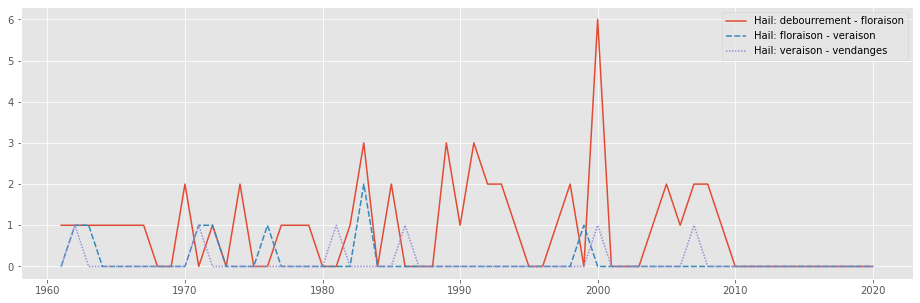

In [175]:
hail_features = []
for feature in list(df.columns):
    if 'Hail' in feature:
        hail_features.append(feature)
        
plt.figure(figsize=(16,5))
sns.lineplot(data=df[hail_features])
plt.show()

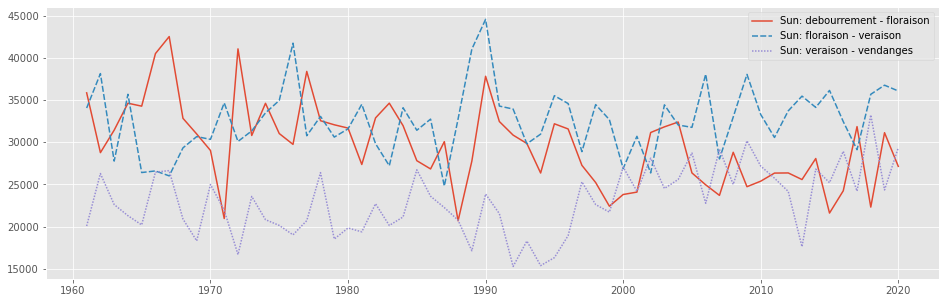

In [176]:
sun_features = []
for feature in list(df.columns):
    if 'Sun' in feature:
        sun_features.append(feature)
        
plt.figure(figsize=(16,5))
sns.lineplot(data=df[sun_features])
plt.show()

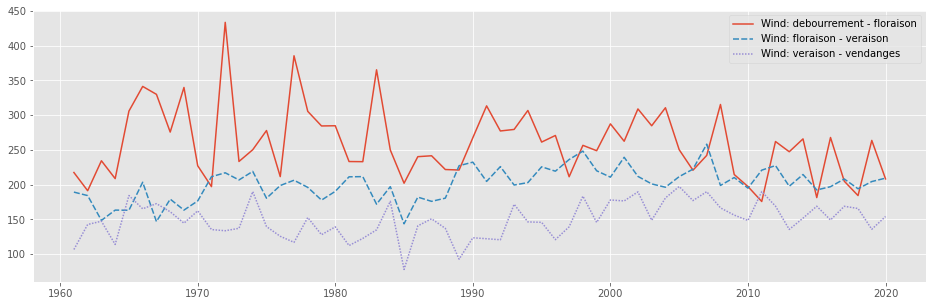

In [177]:
wind_features = []
for feature in list(df.columns):
    if 'Wind' in feature:
        wind_features.append(feature)
        
plt.figure(figsize=(16,5))
sns.lineplot(data=df[wind_features])
plt.show()

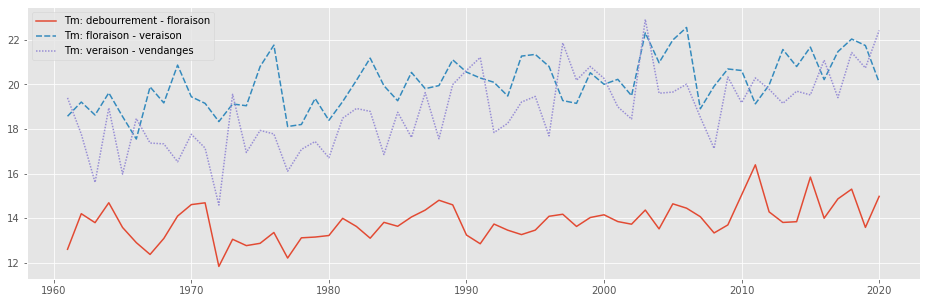

In [178]:
tmp_features = []
for feature in list(df.columns):
    if 'Tm' in feature:
        tmp_features.append(feature)
        
plt.figure(figsize=(16,5))
sns.lineplot(data=df[tmp_features])
plt.show()

,Price
Vintage,
1950,479.821429
1951,701.875000
1952,243.000000
1953,679.178571
1954,721.000000


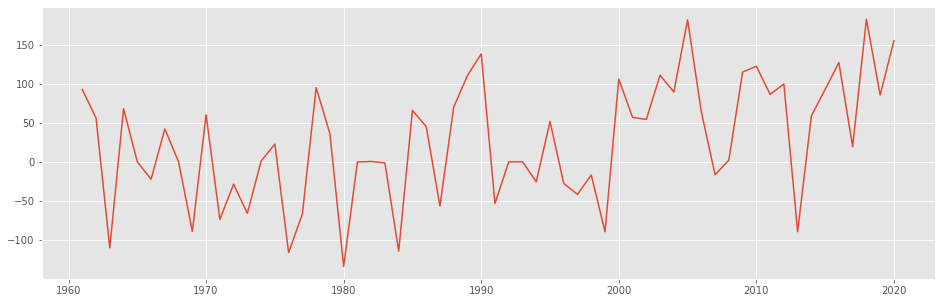

In [183]:
df[['Debourrement-floraison interval', 'Floraison-veraison interval', 'Veraison-Harvest interval']] = pheno[['Debourrement-floraison interval', 'Floraison-veraison interval', 'Veraison-Harvest interval']]
prices = pd.read_excel('data/generated_average_prices.xlsx', index_col=0)
display(prices.head())

df['Tm Growing Season'] = df['Tm: debourrement - floraison'] + df['Tm: floraison - veraison'] + df['Tm: veraison - vendanges']
df['Stress'] = 0.5*(df['ETPmon: floraison - veraison'] + df['ETPmon: veraison - vendanges']) - (df['P: floraison - veraison'] + df['P: veraison - vendanges'])
df['Stress'] = (df['Stress'] > -150).astype(int) * df['Stress']
df['Huglin Growing Season'] = df['Huglin: debourrement - floraison'] + df['Huglin: floraison - veraison'] + df['Huglin: veraison - vendanges']

df['Log price'] = np.log(prices['Price'])

plt.plot(df['Stress'])

<AxesSubplot:>

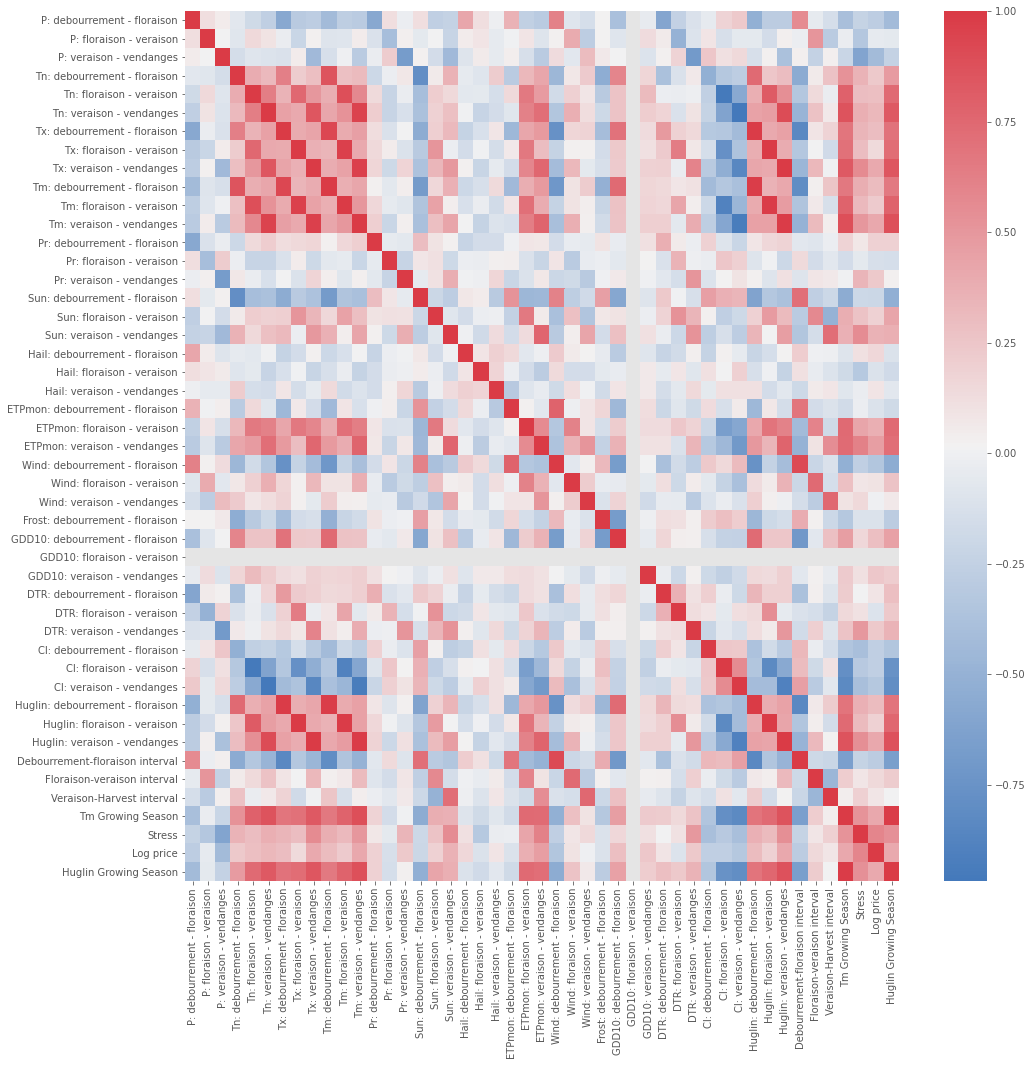

In [184]:
plt.figure(figsize=(16,16))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(df.corr(), cmap=cmap)

P


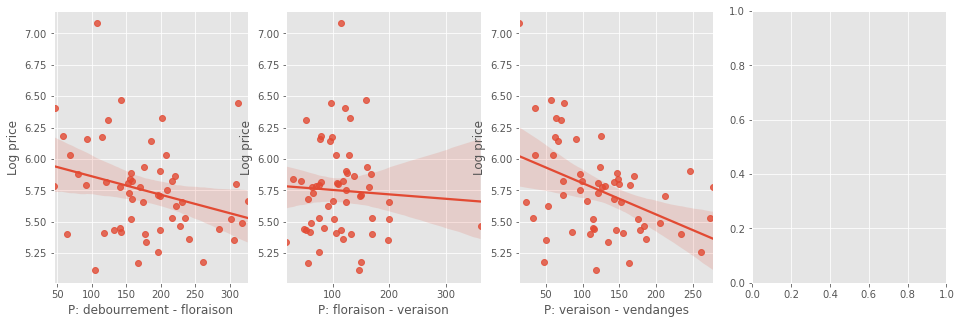

Tn


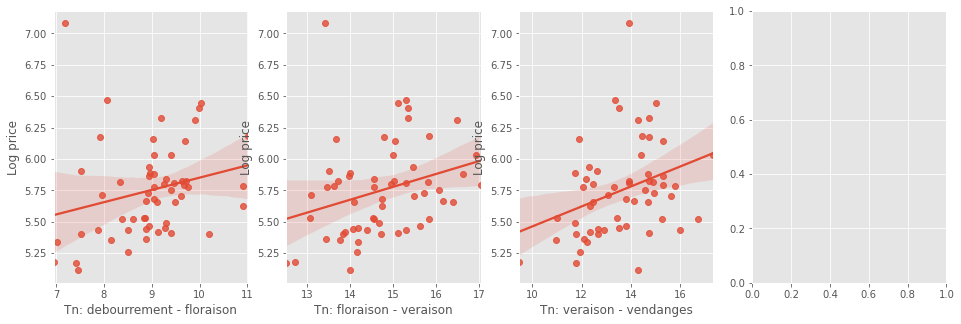

Tx


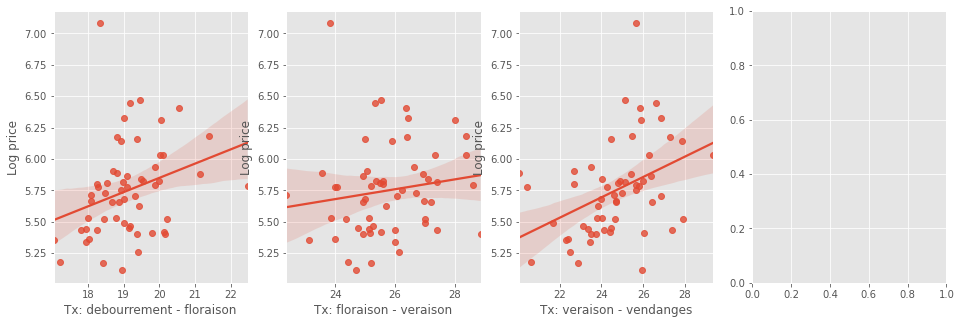

Tm


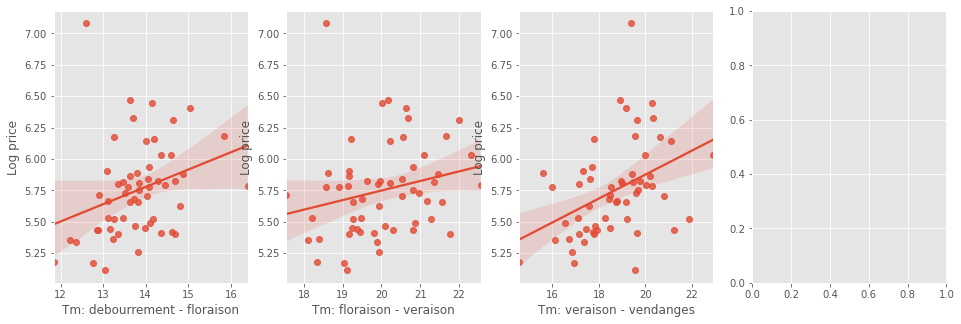

Pr


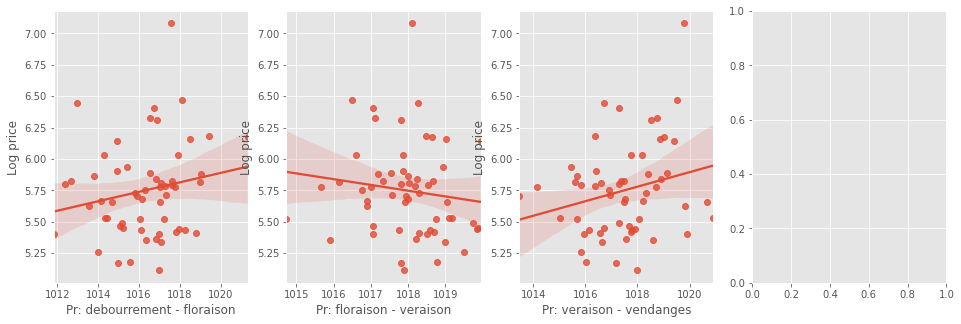

Sun


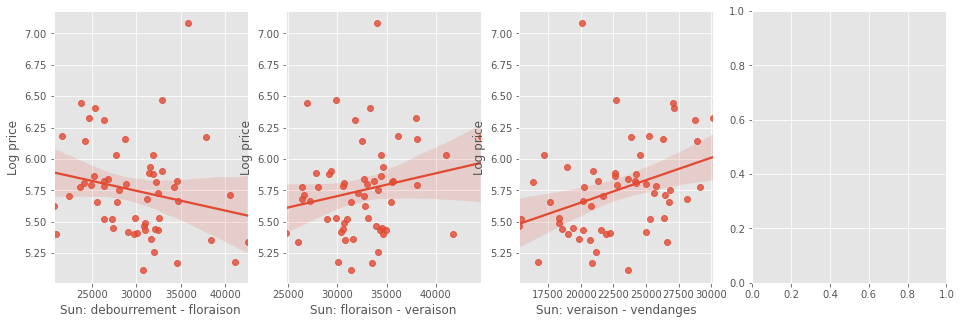

Hail


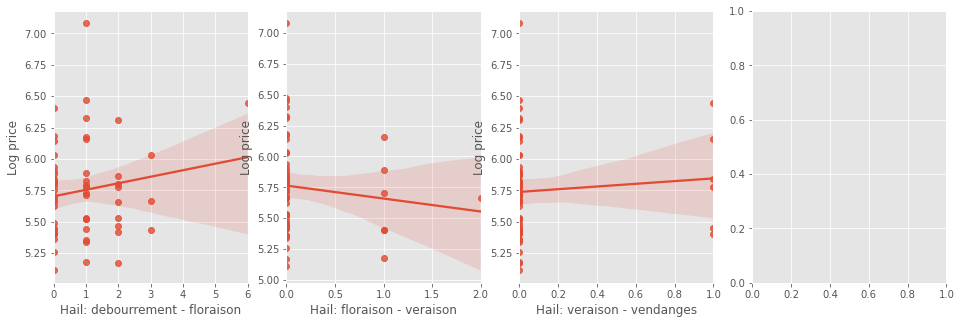

ETPmon


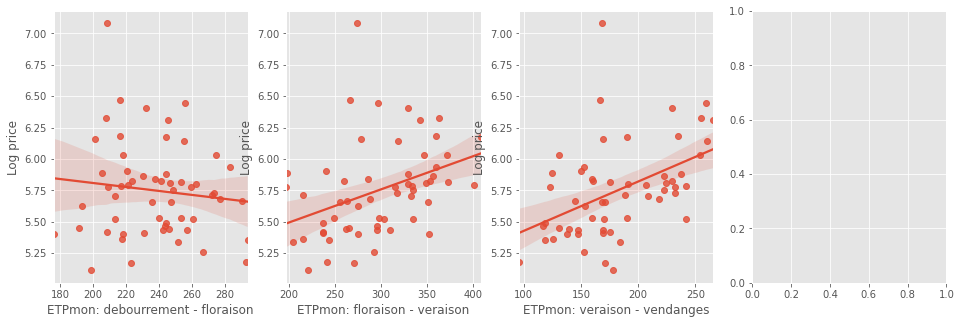

Wind


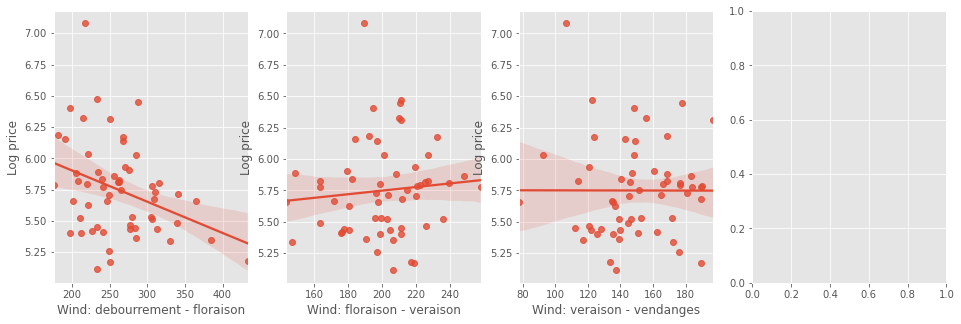

Frost


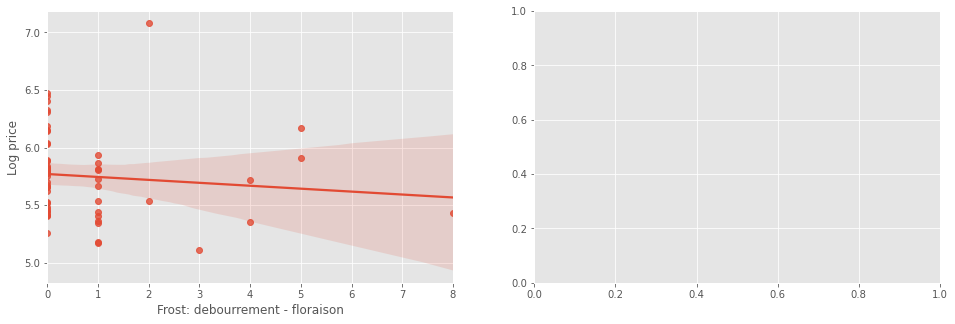

In [61]:
features = list(df.columns)
features.remove('Log price')
for orig_feature in ORIG_WEATHER_FEATURES:
    print(orig_feature)
    to_plot = [feature for feature in features if orig_feature+':' in feature]
    fig, axes = plt.subplots(1, len(to_plot)+1)
    
    for i in range(len(to_plot)):
        sns.regplot(ax = axes[i], x = df[to_plot[i]], y = df['Log price'])
    plt.show()

In [185]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

df=df.loc[1961:2017]
X = df.drop('Log price', axis=1).reset_index().rename(columns={'index':'vintage'})
y = df[['Log price']]


linreg = LinearRegression()
#forest = RandomForestRegressor(n_estimators=10, max_depth=10)
tree = DecisionTreeRegressor(max_depth=10)
rfe = RFE(tree, n_features_to_select=8)
rfe.fit(X,y.values.ravel())
print(rfe.score(X,y))
supp = rfe.support_
#print(export_text(rfe.estimator_))

sel_features = []
for i in range(len(list(X.columns))):
    if supp[i]:
        sel_features.append(list(X.columns)[i])
print(sel_features)


GOOD_FEATURES = ['Huglin Growing Season','Stress', 'P: veraison - vendanges', 'DTR: veraison - vendanges']
X = X[GOOD_FEATURES]
#X['Sq Tn: debourrement - floraison'] = X['Tn: debourrement - floraison']**2

0.9989767835110276
['Tn: debourrement - floraison', 'Tm: floraison - veraison', 'Pr: floraison - veraison', 'Pr: veraison - vendanges', 'Sun: veraison - vendanges', 'DTR: debourrement - floraison', 'CI: debourrement - floraison', 'Stress']


#### GOOD_FEATURES = ['Stress', 'P: veraison - vendanges', 'DTR: veraison - vendanges']: Spearman out-sample of 0.70, BEST TO DATE

In [186]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

def model_tester(X, y):
    coefficients = pd.DataFrame(0, index = ['const']+X.columns.to_list(), columns=range(1961,1997))
    r2_scores = []
    predictions = pd.DataFrame(index=range(1982,2018), columns=['Log Price'])
    spearman_scores = []
    X = pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns)

    for year in coefficients:
        oldest_vintage = year
        newest_vintage = year + 20

        y_train = y.loc[oldest_vintage:newest_vintage, 'Log price']
        X_train = sm.add_constant(X.loc[oldest_vintage-1961:newest_vintage-1961,:])
        
        mod = sm.OLS(y_train.values.reshape(-1,1), X_train)
        res = mod.fit()
        coefs = pd.Series(res.params)
        coefficients[year] = coefs
        
        r2_scores.append(r2_score(res.predict(X_train),y_train))
        spearman_scores.append(spearmanr(res.predict(X_train),y_train)[0])
        
        
        X_test = X.loc[newest_vintage-1961+1:newest_vintage-1961+1,:]
        ones = pd.DataFrame(np.ones(1), index=[newest_vintage-1961+1], columns=['const'])
        
        X_test = pd.concat((ones, X_test), axis=1)
        

        predictions.loc[newest_vintage+1] = res.predict(X_test.values)[0]
    
    return coefficients, r2_scores, spearman_scores, predictions

coefficients, r2_scores, spearman_scores, predictions = model_tester(X, y)
display(predictions)

,Log Price
1982,5.77578
1983,5.85658
1984,5.27982
1985,5.34258
1986,5.59508
1987,5.6072
1988,5.75503
1989,5.97819
1990,5.84114
1991,5.56212


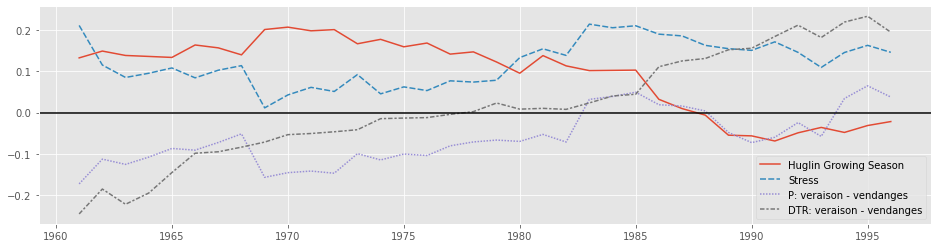

<Figure size 1152x288 with 0 Axes>

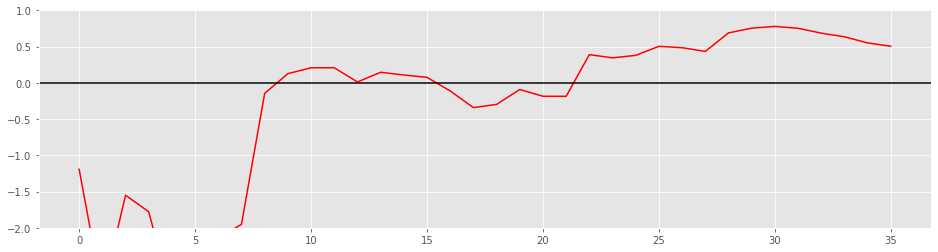

Average in-sample R2 score over the whole period:  -0.26236611465349896


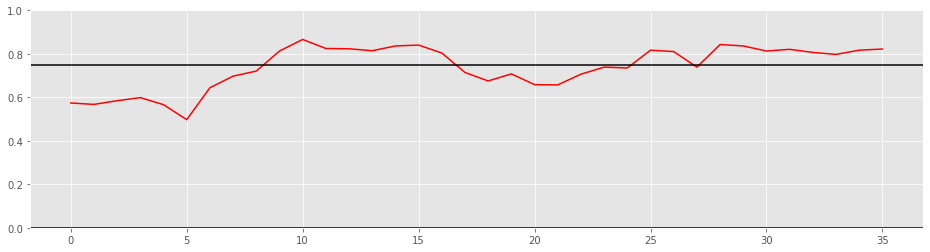

Average in-sample Spearman R over the whole period:  0.7385642135642135


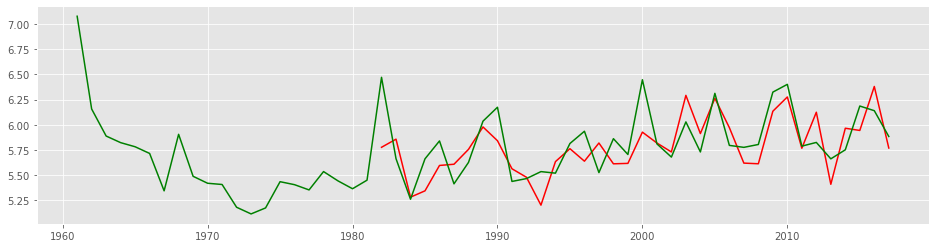

Average out-sample Spearman R over the whole period:  0.6803088803088804


In [187]:
plt.figure(figsize=(16,4))
sns.lineplot(data=coefficients.T.iloc[:,1:6]).axhline(0., color='black')
plt.show()

plt.figure(figsize=(16,4))
#sns.lineplot(data=coefficients.T.iloc[:,6:]).axhline(0., color='black')
plt.show()

plt.figure(figsize=(16,4))
sns.lineplot(data=r2_scores, color='red').axhline(0., color='black')
plt.ylim((-2,1))
plt.plot(0)
plt.savefig('views/In-sample_R2_simple_regression.png')
plt.show()
print('Average in-sample R2 score over the whole period: ',np.mean(r2_scores))

plt.figure(figsize=(16,4))
sns.lineplot(data=spearman_scores, color='red').axhline(0., color='black')
plt.ylim((0,1))
plt.axhline(0.75, color='black')
plt.savefig('views/In-sample_Spearman_R_simple_regression.png')
plt.show()
print('Average in-sample Spearman R over the whole period: ',np.mean(spearman_scores))


plt.figure(figsize=(16,4))
plt.plot(predictions, color='red')
plt.plot(y, color='green')

plt.savefig('views/Spearman_R_simple_regression.png')
plt.show()

print('Average out-sample Spearman R over the whole period: ',spearmanr(predictions.loc[1982:2017], y.loc[1982:2017])[0])

# Appendix: PCA

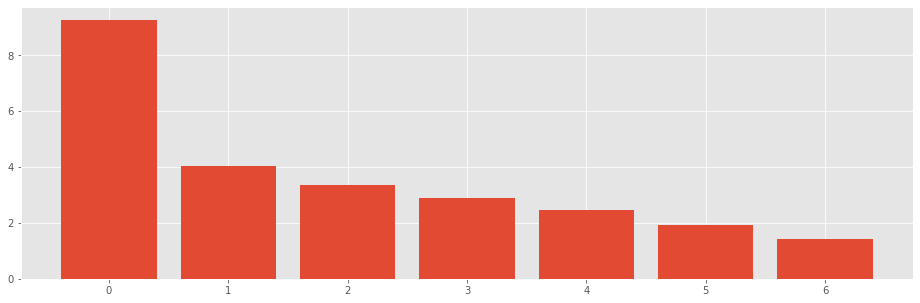

[[-0.25537866  0.16918682 -0.00936519  0.05166569 -0.20758502 -0.22347927
  -0.25170422 -0.25400275 -0.18574642 -0.24461919 -0.25380538 -0.2113947
  -0.26009887 -0.0596556   0.05618896  0.00379904  0.23446221 -0.11800104
  -0.12784445  0.03310655  0.06986974 -0.02341812  0.10128256 -0.25315676
  -0.25052627  0.22150061 -0.14346534 -0.06909845  0.13028014  0.26391176
  -0.11170013 -0.04765236]
 [ 0.0813743   0.09280081  0.18409184 -0.0090696  -0.18441865  0.18651478
   0.12939023 -0.15375093  0.18647591  0.11269963 -0.20127002  0.20450679
   0.12413916  0.03546882 -0.01027676 -0.10114508  0.11626515  0.25418756
  -0.2736013   0.03098375  0.01418401 -0.16941876  0.20346788  0.25218422
  -0.09189019  0.16584781  0.18691063 -0.22584042  0.15317368  0.16355807
   0.27803797 -0.38412174]
 [-0.21366853 -0.12945506  0.10469434 -0.05689404  0.03492039 -0.16014297
  -0.15317091  0.14112224 -0.03468117 -0.06865814  0.11566965 -0.07963759
  -0.11452432 -0.01067919  0.03287995  0.15557131 -0.116387

In [492]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create scaler: scaler
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA(n_components=7)

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,pca)

pipeline.fit(X.dropna(axis=0))
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.show()
print(pca.components_)

X = X.dropna(axis=0)
X2 = pd.DataFrame(pca.transform(X), index=X.index)

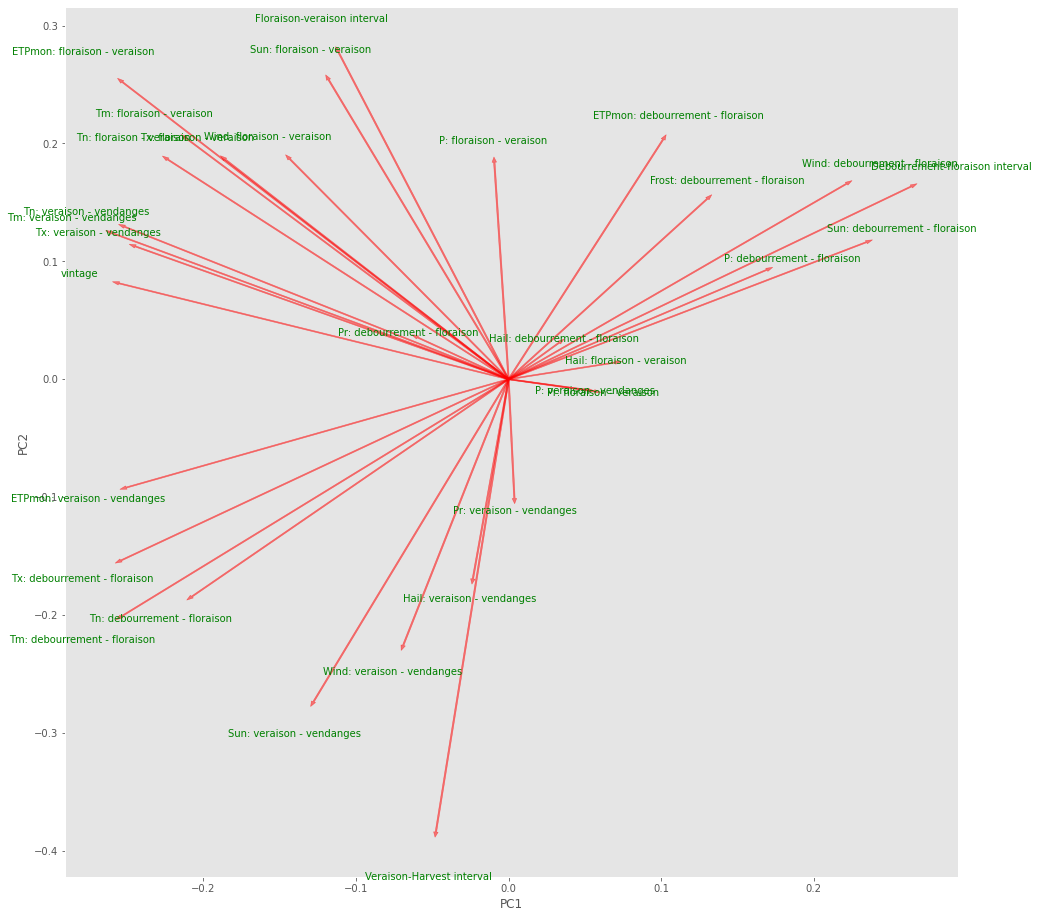

In [498]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    #plt.scatter(xs ,ys) #without scaling
    for i in range(len(labels)):
        plt.arrow(0, 0, coeff[0,i], coeff[1,i],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[0,i]* 1.10, coeff[1,i] * 1.10, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[0,i]* 1.10, coeff[1,i] * 1.10, labels[i], color = 'g', ha = 'center', va = 'center')

plt.figure(figsize=(16,16))
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. 
myplot(X2.values[:,0:2], pca.components_, list(X.columns)) 
plt.show()